In [49]:
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from datetime import datetime, timedelta
import cartopy
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
from sklearn.metrics import mean_squared_error

In [59]:

# Example THREDDS URL for GFS temperature data
thredds_url = "https://thredds.ucar.edu/thredds/dodsC/grib/NCEP/RAP/CONUS_13km/RR_CONUS_13km_20240919_2200.grib2"

# Load the GFS temperature data
dataset = xr.open_dataset(thredds_url)

# Extract 3D temperature data (latitude, longitude, pressure level)
temperature_3d = dataset['Temperature_height_above_ground']

# Get  time steps (assuming  time indices in the dataset)
time_obs = dataset['time'].values[0]
time_pred = dataset['time'].values[1]

# Extract  temperature observations (raw  input)
temperature_obs = temperature_3d.sel(time=time_obs)

# Extract  temperature prediction (model forecast)
temperature_pred = temperature_3d.sel(time=time_pred)

latitude_of_projection_origin = dataset['LambertConformal_Projection'].latitude_of_projection_origin
longitude_of_central_meridian = dataset['LambertConformal_Projection'].longitude_of_central_meridian
standard_parallel = dataset['LambertConformal_Projection'].standard_parallel

coordref = ccrs.LambertConformal(
    central_longitude=longitude_of_central_meridian,
    central_latitude=latitude_of_projection_origin,
    #standard_parallels=[standard_parallel]
    )



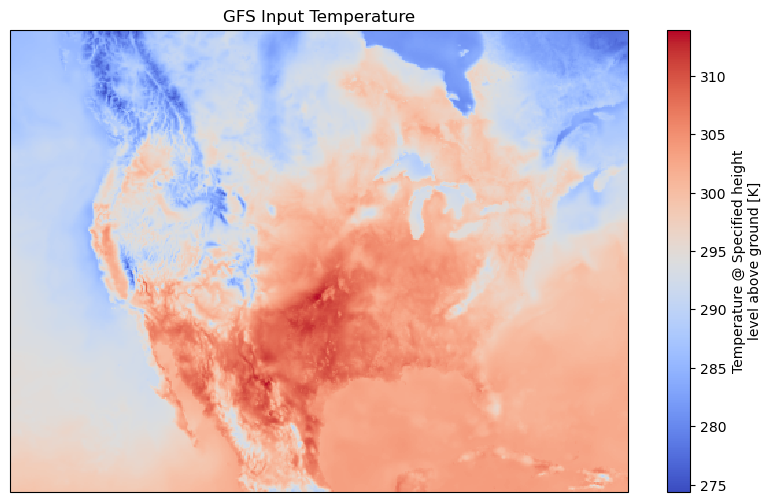

In [64]:

# Plot temperature obs using Cartopy
plt.figure(figsize=(10, 6))
ax = plt.axes(projection=coordref)
temperature_obs.plot(ax=ax, cmap='coolwarm')
ax.coastlines(linewidth=5)
plt.title("GFS Input Temperature")
plt.show()

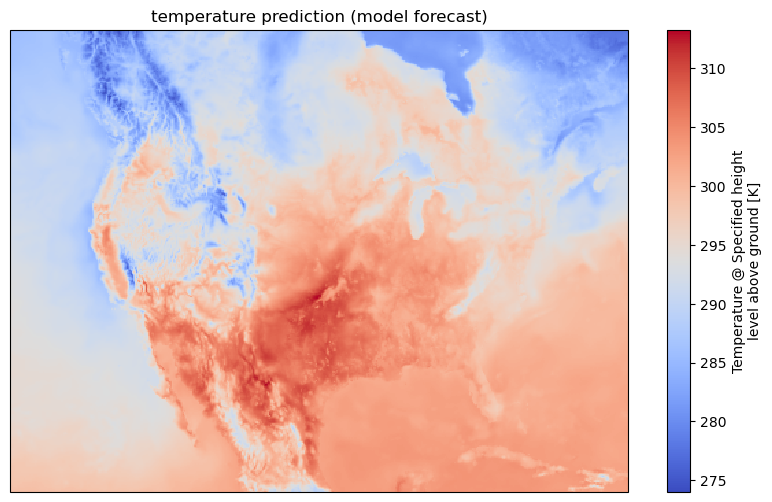

In [66]:
# Plot the temperature prediction (model forecast)
plt.figure(figsize=(10, 6))
ax = plt.axes(projection=coordref)
temperature_pred.plot(ax=ax, cmap='coolwarm')
ax.coastlines()
plt.title("temperature prediction (model forecast)")
plt.show()

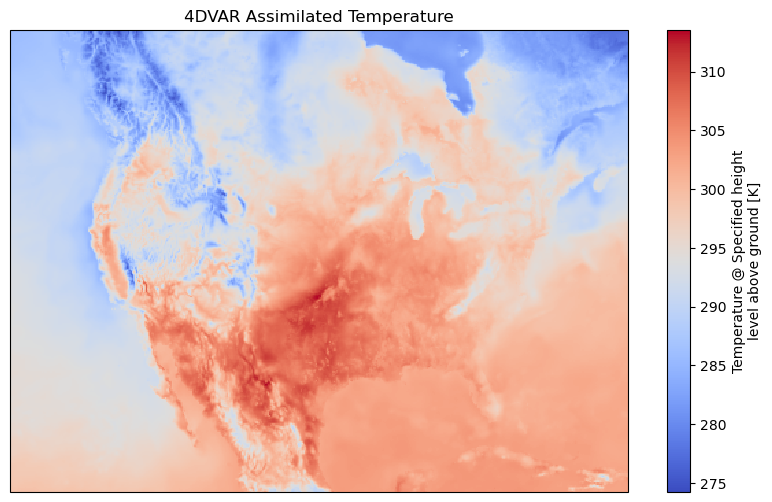

In [65]:


# Now we perform 4DVAR by minimizing the difference between predictions and observations
# This is a simplified 4DVAR loop (using direct difference rather than full optimization).

# Initialize analysis state as the forecast (first guess)
analysis_state = temperature_pred.copy()

# Assimilation step: update the analysis state based on observation and prediction
alpha = 0.5  # weight for assimilation (can be determined through minimization)
analysis_state.values = alpha * temperature_obs.values + (1 - alpha) * temperature_pred.values

# Plot the updated analysis state after assimilation
plt.figure(figsize=(10, 6))
ax = plt.axes(projection=coordref)
analysis_state.plot(ax=ax, cmap='coolwarm')
ax.coastlines()
plt.title("4DVAR Assimilated Temperature")
plt.show()


In [ ]:


# Flatten the data for RMSE calculation
obs_flat = temperature_obs.values.flatten()
pred_flat = temperature_pred.values.flatten()
analysis_flat = analysis_state.values.flatten()

# Compute RMSE for the forecast (before assimilation) and the analysis (after assimilation)
rmse_pred = np.sqrt(mean_squared_error(obs_flat, pred_flat))
rmse_analysis = np.sqrt(mean_squared_error(obs_flat, analysis_flat))

print(f"RMSE before assimilation (Prediction): {rmse_pred}")
print(f"RMSE after assimilation (Analysis): {rmse_analysis}")
